In [16]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
# Load dataset
df = pd.read_csv("final_version.csv", low_memory=False)
df.shape

(56858, 10)

In [17]:
# df['prix'] = np.log(df['prix'] + 1)

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define features
categorical_features = ["Transmission", "Carburant", "marque", "modele", "premierMain"]
numerical_features = ["Kilométrage", "Année", "CV"]

# Make a copy of the original DataFrame (optional, for safety)
df_encoded = df.copy()

# Ensure categorical columns are strings
df_encoded[categorical_features] = df_encoded[categorical_features].astype(str)

# Apply Label Encoding to each categorical column
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Optional: Save encoder for inverse_transform or inference

# Standardize numerical features
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Final feature matrix and target
X = df_encoded[categorical_features + numerical_features]
y = df_encoded["prix"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Définir les caractéristiques et la variable cible
# Assurez-vous que X et y sont définis avant cette cellule

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Meilleurs hyperparamètres (vous pouvez les ajuster pour CatBoost si nécessaire)
best_params = {
    'iterations': 7199,
    'learning_rate': 0.04,
    'depth': 7,
    'subsample': 0.9,
    'l2_leaf_reg': 1,
    'random_seed': 42,
    'verbose': 100
}

# Création du modèle CatBoost
model = CatBoostRegressor(**best_params)

# Entraînement du modèle
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=False, plot=True)

# Prédictions sur les données de test
y_pred = model.predict(X_test)
print("the prediction ", y_pred)

# Évaluation
r2 = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Affichage des performances
print("🔍 Évaluation du modèle CatBoost")
print(f"✅ Accuracy (R² Score)        : {r2:.2f}")
print(f"📉 Mean Absolute Error (MAE) : {mae:.2f}")
print(f"📉 Mean Squared Error (MSE)  : {mse:.2f}")
print(f"📉 Root Mean Squared Error   : {rmse:.2f}")

# Sauvegarde du modèle
joblib.dump(model, 'catboost_model.pkl')  # Uncomment if needed


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 87847.2985037	test: 87771.4362968	best: 87771.4362968 (0)	total: 9.47ms	remaining: 1m 8s
100:	learn: 37108.2988754	test: 37581.5741383	best: 37581.5741383 (100)	total: 760ms	remaining: 53.4s
200:	learn: 33996.4274119	test: 34418.3499475	best: 34418.3499475 (200)	total: 2.21s	remaining: 1m 17s
300:	learn: 32191.0316002	test: 32624.0036023	best: 32624.0036023 (300)	total: 3.18s	remaining: 1m 12s
400:	learn: 30957.6846874	test: 31473.5662091	best: 31473.5662091 (400)	total: 4.28s	remaining: 1m 12s
500:	learn: 30016.1886339	test: 30616.5423552	best: 30616.5423552 (500)	total: 5.75s	remaining: 1m 16s
600:	learn: 29245.0963608	test: 30023.5886812	best: 30023.5886812 (600)	total: 6.99s	remaining: 1m 16s
700:	learn: 28643.4900835	test: 29560.8948333	best: 29560.8948333 (700)	total: 8.2s	remaining: 1m 16s
800:	learn: 28090.8755276	test: 29143.7736228	best: 29143.7736228 (800)	total: 9.88s	remaining: 1m 18s
900:	learn: 27627.9407425	test: 28856.9638872	best: 28856.9638872 (900)	total: 

['catboost_model.pkl']

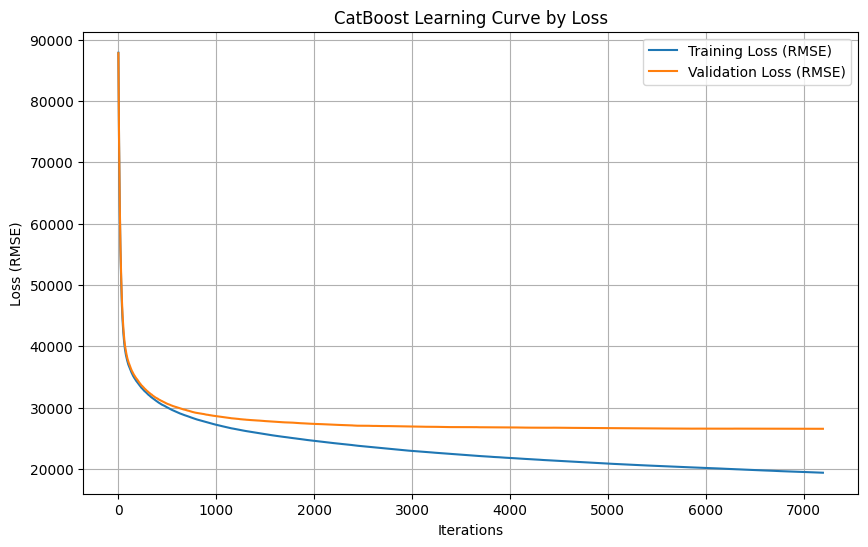

In [20]:
# Récupérer les résultats d'évaluation (loss par itération)
eval_results = model.get_evals_result()

# Extraire la courbe de perte (ici 'RMSE' par défaut pour regression)
train_loss = eval_results['learn']['RMSE']
test_loss = eval_results['validation']['RMSE']

# Tracer la courbe de perte
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss (RMSE)')
plt.plot(test_loss, label='Validation Loss (RMSE)')
plt.xlabel('Iterations')
plt.ylabel('Loss (RMSE)')
plt.title('CatBoost Learning Curve by Loss')
plt.legend()
plt.grid(True)
plt.show()